# CAML-PAD

### Input Type: Meraki_Logs

##### Import Statements

In [1]:
print("INSTALLED LIBRARIES")
print("*************************")

import pandas as pd
print('Pandas: {:s}'.format(pd.__version__))
import numpy as np
print('Numpy: {:s}'.format(np.__version__))
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
print('Scikit Learn Version:', sklearn.__version__)
import matplotlib.pyplot as plt
# print('MatplotLib Version:', matplotlib.__version__)
import os
import math
import datetime
import pyod

INSTALLED LIBRARIES
*************************
Pandas: 0.24.2
Numpy: 1.16.2
Scikit Learn Version: 0.20.3


##### ElasticSearch Database Connection Established

In [2]:
from elasticsearch import Elasticsearch

print("ELASTICSEARCH INFORMATION")
print("*************************")

print("Connecting to {host} on port {port}...".format(host='172.16.8.70', port='9200'))

es = Elasticsearch([{'host': '{host}', 'port': {port}}])

if es.ping():
    print(" \nCONNECTION: Established")
else:
    print("\nCONNECTION: Failed")

ELASTICSEARCH INFORMATION
*************************
Connecting to 172.16.8.70 on port 9200...
 
CONNECTION: Established


##### Defining Functions

In [3]:
today = str(datetime.datetime.today())
yrIndex = today.find('-')

year = today[:yrIndex]

monthIndex = today[yrIndex+1:].find('-')

month = today[yrIndex+1:][:monthIndex]

dayIndex = today[yrIndex+1:][monthIndex+1:].find(' ')
day = today[yrIndex+1:][monthIndex+1:][:dayIndex]

this_tens, this_ones = divmod(int(day), 10)
this_month = int(month)

print("CURRENT DATE")
print("************")

print("Year: {year}\nMonth: {month}\nDay: {day}".format(year=year, month=month, day=day))

CURRENT DATE
************
Year: 2019
Month: 07
Day: 23


In [4]:
def setParams(size, init_month, init_tenths, init_ones, log_type):

    size = size
    init_month = init_month
    init_tenths = init_tenths
    init_ones = init_ones
    hasModified = False



    extraDayL = [1,3,5,7,8,10,12]

    extraDay = False if int(this_month) in extraDayL else True


    if init_month < 10:
        print_init_month = "0{month}".format(month=init_month)
    else:
        print_init_month = init_month


    if this_ones == 1 and this_tens == 0:
        iter_month = this_month - 1
        iter_tens = 3
        iter_ones = 1 if extraDay else 0
        hasModified = True
    else:
        iter_month = this_month

    if this_ones == 0 and (not hasModified):
        iter_tens = this_tens - 1
        iter_ones = 9
        hasModified = True
    elif hasModified:
        a = 1
    else:
        iter_tens = this_tens

    if not hasModified:
        iter_ones = this_ones - 1

    if iter_month < 10:
        print_month = "0{month}".format(month=iter_month)
    else:
        print_month = iter_month



    print("TRAINING INFO")
    print("*************")

    print("Importing {atype} Logs of size {size} from {initMonth}/{initTenths}{initOnes} to {Month}/{Tenths}{Ones}..."
          .format(size=size, initMonth=print_init_month, initTenths=init_tenths, initOnes=init_ones, 
                  Month=print_month, Tenths=iter_tens, Ones=iter_ones, atype=log_type))   
    return size, init_month, init_tenths, init_ones, iter_month, iter_tens, iter_ones, extraDayL


In [5]:
def findData(month, tens, ones, log_type, listNum):
    if log_type == 'meraki':
        indexVal = 'meraki_2019'
    else:
        indexVal = '{alog}_index_2019'.format(alog=log_type)
        
#     print('{aindex}.{month}.{tenDay}{day}'.format(month=month, tenDay=tens, day=ones, aindex=indexVal))
    try:
        res = es.search(
            index='{aindex}.{month}.{tenDay}{day}'.format(month=month, tenDay=tens, day=ones, aindex=indexVal), 
            body={"query": {"match_all": {}}, "size": size})
    except:
#         print("error")
        return "ERROR"
#     print(res['hits']['hits'])

    ids = [d['_id'] for d in res['hits']['hits']]

    mylist = []
    index = []


#     print(list(res['hits']['hits'][0].get('_source').values()))


    for x in range(size):
        sourceD = res['hits']['hits'][x].get('_source')

        for key, value in sourceD.items():
            xx = any(c.isalpha() for c in str(value))

            if not xx:
                try:
                    newstr = float(value)
                except:
                    newstr = value
            else:
                newstr = value

            sourceD[key] = newstr


        mylist.append(sourceD)
        index.append(x + listNum)


    bro_dfX = pd.DataFrame(mylist, index=index)
    return bro_dfX

In [6]:
def iterateOldData(log_type):
    
    listNum = 0
    init_ten_day = init_tenths
    final_ten_day = 3

    init_one_day = init_ones
    final_one_day = 9

    bro_dfL = []

    finalMonth = False

    init = True
    errInit = True

    err = []

    print("DATA METRICS")
    print("************")
    print("DAYS COMPLETED:", end = " ")

    for aMonth in range(init_month, iter_month+1):

        if aMonth < 10:
            input_month = "0{}".format(aMonth)
        else:
            input_month = aMonth

        finalMonth = aMonth == iter_month
        final_ten_day = iter_tens if finalMonth else 3

        for tenDay in range(init_ten_day, final_ten_day + 1):

            if not init:
                init_one_day = 0 if tenDay != 0 else 1

            finalTens = tenDay == iter_tens
            final_one_day = iter_ones if finalTens else 9

            for oneDay in range(init_one_day, final_one_day + 1):

                anExtraDay = True if int(aMonth) in extraDayL else False
                day_break = False

                bro_dfI = findData(input_month, tenDay, oneDay, log_type, listNum)
                
#                 print(bro_dfI.head())

                thisDay = "{}/{}{},".format(input_month, tenDay, oneDay)

                if not isinstance(bro_dfI, str):
                    bro_dfL.append(bro_dfI)
                    print(thisDay, end =" ")  
                else:
                   err.append(thisDay)

                if tenDay == 3:
                    if anExtraDay:
                        if oneDay == 1:
                            break
                    else:
                        if oneDay == 0:
                            break

                init = False


        init_ten_day = 0

    print("\nERROR:", end=" ")
    for day in err:
        print(day, end =" ") 
    bro_df = pd.concat(bro_dfL, sort = True)
    return bro_df

In [7]:
def iterateNewData(log_type):
    listNum = 0
    err = []

    if this_month < 10:
        my_month = "0{}".format(this_month)
    else:
        my_month = this_month

    print("TESTING DATA")
    print("************")
    print("DAYS COMPLETED:", end = " ")    

    bro_dfT = findData(my_month, this_tens, this_ones, 'bro', listNum)

    thisDay = "{}/{}{}".format(this_month, this_tens, this_ones)

    if not isinstance(bro_dfT, str):
        print(thisDay, end =" ")  

    else:
        print("NO DATA FOR THIS DAY", end= " ")\
        
    return bro_dfT

##### Importing Bro Logs as DataFrame

In [8]:
size, init_month, init_tenths, init_ones, iter_month, iter_tens, iter_ones, extraDayL = setParams(5000, 6, 2, 1, 'Bro')

TRAINING INFO
*************
Importing Bro Logs of size 5000 from 06/21 to 07/22...


In [9]:
bro = iterateOldData('bro')
bro.head()

DATA METRICS
************
DAYS COMPLETED: 06/21, 06/22, 

GET /bro_index_2019.07.01/_search [status:404 request:0.002s]


06/30, 07/02, 07/03, 07/04, 

GET /bro_index_2019.07.06/_search [status:404 request:0.003s]
GET /bro_index_2019.07.07/_search [status:404 request:0.001s]


07/05, 07/08, 07/09, 07/10, 07/11, 07/12, 07/13, 07/14, 07/15, 07/16, 07/17, 07/18, 07/19, 07/20, 07/21, 07/22, 
ERROR: 07/01, 07/06, 07/07, 

,AA,RA,RD,TC,TTLs,Z,adapter:geoadapter:begin:ts,adapter:geoadapter:end:ts,adapter:hostfromjsonlistadapter:begin:ts,adapter:hostfromjsonlistadapter:end:ts,...,status_msg,tags,timestamp,trans_depth,trans_id,tunnel_parents,uid,uri,user_agent,version
0,False,False,False,False,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.561144e+12,NaN,39176.0,NaN,CTzrlI18YKQ8PsUWH,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.561144e+12,NaN,NaN,[],CSPB7M23X9KJ4L6Rh4,NaN,NaN,NaN
2,False,False,False,False,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.561144e+12,NaN,30950.0,NaN,CV6xyc2iw5FMyJykfl,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.561144e+12,NaN,NaN,[],CfFlZn2yjw76Dkjom2,NaN,NaN,NaN
4,False,False,True,False,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.561144e+12,NaN,64712.0,NaN,CXmmzP3KRYAVwcrHbf,NaN,NaN,NaN


In [10]:
bro_test = iterateNewData('bro')
bro_test.head()

TESTING DATA
************
DAYS COMPLETED: 7/23 

,AA,RA,RD,TC,TTLs,Z,answers,bro_timestamp,conn_state,duration,...,status_msg,tags,timestamp,trans_depth,trans_id,tunnel_parents,uid,uri,user_agent,version
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.563861e+09,SF,61.006888,...,NaN,NaN,1.563861e+12,NaN,NaN,[],CHHLf73E9NNkYvwWw3,NaN,NaN,NaN
1,False,False,False,False,NaN,0.0,NaN,1.563861e+09,NaN,NaN,...,NaN,NaN,1.563861e+12,NaN,31744.0,NaN,C3nORa3Vh8wPOymhld,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.563861e+09,SF,0.018265,...,NaN,NaN,1.563861e+12,NaN,NaN,[],COC6S62EesBGzqy61i,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.563861e+09,S0,0.392537,...,NaN,NaN,1.563861e+12,NaN,NaN,[],CaBTvw1IIGscxDzuda,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.563861e+09,S0,224.431218,...,NaN,NaN,1.563861e+12,NaN,NaN,[],CUcigt3CzPl3RCy9J3,NaN,NaN,NaN


In [11]:
size, init_month, init_tenths, init_ones, iter_month, iter_tens, iter_ones, extraDayL = setParams(10000, 5, 3, 0, 'Yaf')

TRAINING INFO
*************
Importing Yaf Logs of size 10000 from 05/30 to 07/22...


In [12]:
yaf = iterateOldData('yaf')
yaf.head()

DATA METRICS
************
DAYS COMPLETED: 05/30, 05/31, 06/01, 06/02, 06/03, 06/04, 06/05, 06/06, 06/07, 06/08, 06/09, 06/10, 

GET /yaf_index_2019.06.12/_search [status:404 request:0.002s]
GET /yaf_index_2019.06.13/_search [status:404 request:0.002s]
GET /yaf_index_2019.06.14/_search [status:404 request:0.001s]
GET /yaf_index_2019.06.15/_search [status:404 request:0.006s]
GET /yaf_index_2019.06.16/_search [status:404 request:0.004s]
GET /yaf_index_2019.06.17/_search [status:404 request:0.002s]
GET /yaf_index_2019.06.18/_search [status:404 request:0.001s]
GET /yaf_index_2019.06.19/_search [status:404 request:0.007s]
GET /yaf_index_2019.06.20/_search [status:404 request:0.004s]


06/11, 06/21, 06/22, 06/30, 07/01, 07/02, 07/03, 07/04, 07/05, 07/06, 07/07, 07/08, 07/09, 07/10, 07/11, 07/12, 07/13, 07/14, 07/15, 07/16, 07/17, 07/18, 07/19, 07/20, 07/21, 07/22, 
ERROR: 06/12, 06/13, 06/14, 06/15, 06/16, 06/17, 06/18, 06/19, 06/20, 

,adapter:geoadapter:begin:ts,adapter:geoadapter:end:ts,adapter:hostfromjsonlistadapter:begin:ts,adapter:hostfromjsonlistadapter:end:ts,adapter:threatinteladapter:begin:ts,adapter:threatinteladapter:end:ts,app,duration,end_reason,end_time,...,roct,rpkt,rtag,rtt,ruflags,source:type,start_time,tag,timestamp,uflags
0,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,0.0,0.0,idle,1.559243e+12,...,0.0,0.0,0.0,0.0,0.0,yaf,1.559243e+12,0.0,1.559243e+12,0.0
1,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,0.0,0.0,idle,1.559243e+12,...,0.0,0.0,0.0,0.0,0.0,yaf,1.559243e+12,0.0,1.559243e+12,0.0
2,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,0.0,0.0,idle,1.559243e+12,...,0.0,0.0,0.0,0.0,0.0,yaf,1.559243e+12,0.0,1.559243e+12,0.0
3,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,0.0,0.0,idle,1.559243e+12,...,0.0,0.0,0.0,0.0,0.0,yaf,1.559243e+12,0.0,1.559243e+12,0.0
4,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,1.559243e+12,0.0,0.0,idle,1.559243e+12,...,0.0,0.0,0.0,0.0,0.0,yaf,1.559243e+12,0.0,1.559243e+12,0.0


In [13]:
yaf_test = iterateNewData('yaf')
yaf_test.head()

TESTING DATA
************
DAYS COMPLETED: 7/23 

,AA,RA,RD,TC,TTLs,Z,answers,bro_timestamp,conn_state,duration,...,status_msg,tags,timestamp,trans_depth,trans_id,tunnel_parents,uid,uri,user_agent,version
0,False,False,True,False,NaN,1.0,NaN,1.563862e+09,NaN,NaN,...,NaN,NaN,1.563862e+12,NaN,38849.0,NaN,CjnPHP129HbOi0fjMi,NaN,NaN,NaN
1,False,False,True,False,NaN,1.0,NaN,1.563862e+09,NaN,NaN,...,NaN,NaN,1.563862e+12,NaN,38893.0,NaN,CjnPHP129HbOi0fjMi,NaN,NaN,NaN
2,False,False,True,False,NaN,1.0,NaN,1.563862e+09,NaN,NaN,...,NaN,NaN,1.563862e+12,NaN,38896.0,NaN,CjnPHP129HbOi0fjMi,NaN,NaN,NaN
3,False,False,True,False,NaN,1.0,NaN,1.563862e+09,NaN,NaN,...,NaN,NaN,1.563862e+12,NaN,38876.0,NaN,CjnPHP129HbOi0fjMi,NaN,NaN,NaN
4,False,False,True,False,NaN,1.0,NaN,1.563862e+09,NaN,NaN,...,NaN,NaN,1.563862e+12,NaN,38884.0,NaN,CjnPHP129HbOi0fjMi,NaN,NaN,NaN


In [14]:
size, init_month, init_tenths, init_ones, iter_month, iter_tens, iter_ones, extraDayL = setParams(328, 5, 3, 0, 'Snort')

TRAINING INFO
*************
Importing Snort Logs of size 328 from 05/30 to 07/22...


In [15]:
snort = iterateOldData('snort')
snort.head()

DATA METRICS
************
DAYS COMPLETED: 05/30, 

GET /snort_index_2019.06.01/_search [status:404 request:0.002s]
GET /snort_index_2019.06.02/_search [status:404 request:0.001s]


05/31, 06/03, 06/04, 06/05, 06/06, 06/07, 06/08, 06/09, 06/10, 

GET /snort_index_2019.06.12/_search [status:404 request:0.002s]
GET /snort_index_2019.06.13/_search [status:404 request:0.001s]
GET /snort_index_2019.06.14/_search [status:404 request:0.002s]
GET /snort_index_2019.06.15/_search [status:404 request:0.002s]
GET /snort_index_2019.06.16/_search [status:404 request:0.002s]
GET /snort_index_2019.06.17/_search [status:404 request:0.002s]
GET /snort_index_2019.06.18/_search [status:404 request:0.002s]
GET /snort_index_2019.06.19/_search [status:404 request:0.002s]
GET /snort_index_2019.06.20/_search [status:404 request:0.001s]
GET /snort_index_2019.06.21/_search [status:404 request:0.001s]


06/11, 

GET /snort_index_2019.07.01/_search [status:404 request:0.001s]
GET /snort_index_2019.07.02/_search [status:404 request:0.001s]


06/22, 06/30, 07/03, 07/04, 

GET /snort_index_2019.07.06/_search [status:404 request:0.002s]
GET /snort_index_2019.07.07/_search [status:404 request:0.002s]


07/05, 07/08, 07/09, 07/10, 07/11, 07/12, 07/13, 07/14, 07/15, 07/16, 07/17, 07/18, 07/19, 07/20, 07/21, 07/22, 
ERROR: 06/01, 06/02, 06/12, 06/13, 06/14, 06/15, 06/16, 06/17, 06/18, 06/19, 06/20, 06/21, 07/01, 07/02, 07/06, 07/07, 

,adapter:geoadapter:begin:ts,adapter:geoadapter:end:ts,adapter:hostfromjsonlistadapter:begin:ts,adapter:hostfromjsonlistadapter:end:ts,adapter:threatinteladapter:begin:ts,adapter:threatinteladapter:end:ts,dgmlen,enrichments:geo:ip_dst_addr:city,enrichments:geo:ip_dst_addr:country,enrichments:geo:ip_dst_addr:dmaCode,...,tcpseq,tcpwindow,threat:triage:rules:0:comment,threat:triage:rules:0:name,threat:triage:rules:0:reason,threat:triage:rules:0:score,threat:triage:score,timestamp,tos,ttl
0,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,40.0,Boydton,US,560.0,...,0x53908C03,0x0,None,None,None,10.0,10.0,1.559253e+12,0.0,128.0
1,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,78.0,NaN,US,NaN,...,0xD6A9FE65,0x3FE,None,None,None,10.0,10.0,1.559253e+12,0.0,128.0
2,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,40.0,Boydton,US,560.0,...,0xDB529F5,0x0,None,None,None,10.0,10.0,1.559253e+12,0.0,128.0
3,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,40.0,NaN,NaN,NaN,...,0x61AD0CD7,0x0,None,None,None,10.0,10.0,1.559253e+12,0.0,118.0
4,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,1.559239e+12,40.0,NaN,US,NaN,...,0xE7F94695,0xA62,None,None,None,10.0,10.0,1.559254e+12,0.0,64.0


In [16]:
snort_test = iterateNewData('snort')
snort_test.head()

TESTING DATA
************
DAYS COMPLETED: 7/23 

,AA,RA,RD,TC,TTLs,Z,answers,bro_timestamp,conn_state,duration,...,resp_bytes,resp_ip_bytes,resp_pkts,rtt,service,source:type,timestamp,trans_id,tunnel_parents,uid
0,False,False,False,False,NaN,0.0,NaN,1.563861e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,bro,1.563861e+12,45474.0,NaN,CoWLSs4m2RlyUbvoK5
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.563862e+09,SF,0.028750,...,4197.0,710.0,5.0,NaN,ssl,bro,1.563862e+12,NaN,[],CeDNiIdDs0QMxFWo1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.563861e+09,S0,50.683561,...,0.0,0.0,0.0,NaN,dns,bro,1.563861e+12,NaN,[],CqiklkMtfn9iVjSlg
3,False,False,True,False,NaN,1.0,NaN,1.563861e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,bro,1.563861e+12,38680.0,NaN,CqiklkMtfn9iVjSlg
4,False,False,True,False,NaN,1.0,NaN,1.563861e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,bro,1.563861e+12,38678.0,NaN,CqiklkMtfn9iVjSlg


In [17]:
size, init_month, init_tenths, init_ones, iter_month, iter_tens, iter_ones, extraDayL = setParams(10000, 7, 1, 1, 'Meraki')

TRAINING INFO
*************
Importing Meraki Logs of size 10000 from 07/11 to 07/22...


In [18]:
meraki = iterateOldData('meraki')
meraki.head()

DATA METRICS
************
DAYS COMPLETED: 07/11, 07/12, 07/13, 07/14, 07/15, 07/16, 07/17, 07/18, 07/19, 07/20, 07/21, 07/22, 
ERROR: 

,@timestamp,@version,dst,dst_port,firewall,host,mac,meraki_priority,message,pattern,...,request,src,src_port,syslog_pri,tags,timestamp,translated_dst_ip,translated_port,translated_src_ip,type
0,2019-07-11T15:16:06.506Z,1.0,162.129.6.70,443.0,NaN,172.16.8.1,NaN,1.0,<134>1 1562858166.529548120 ip_flow_start src=...,NaN,...,NaN,172.16.20.10,49569.0,134.0,NaN,1.562858e+09,NaN,49569.0,71.127.49.181,ip_flow_start
1,2019-07-11T15:16:06.509Z,1.0,162.129.6.70,443.0,BCMX,172.16.8.1,0C:8D:DB:6F:FD:9E,1.0,<134>1 1562858166.532060248 BCMX flows src=172...,allow tcp && (dst port 443) && (src 172.16.32....,...,NaN,172.16.20.10,49570.0,134.0,NaN,1.562858e+09,NaN,NaN,NaN,flows
2,2019-07-11T15:16:06.511Z,1.0,172.16.8.70,6080.0,BCMX,172.16.8.1,0C:8D:DB:6F:FD:9E,1.0,<134>1 1562858166.534330264 BCMX flows src=172...,deny (dst 172.16.8.0/24) && (src 172.16.32.0/2...,...,NaN,172.16.20.10,5555.0,134.0,NaN,1.562858e+09,NaN,NaN,NaN,flows
3,2019-07-11T15:16:06.513Z,1.0,172.16.8.70,6080.0,BCMX,172.16.8.1,0C:8D:DB:6F:FD:9E,1.0,<134>1 1562858166.536357652 BCMX flows src=172...,deny (dst 172.16.8.0/24) && (src 172.16.32.0/2...,...,NaN,172.16.20.10,5555.0,134.0,NaN,1.562858e+09,NaN,NaN,NaN,flows
4,2019-07-11T15:16:06.513Z,1.0,162.129.6.70,443.0,BCMX,172.16.8.1,0C:8D:DB:6F:FD:9E,1.0,<134>1 1562858166.536404800 BCMX flows src=172...,allow tcp && (dst port 443) && (src 172.16.32....,...,NaN,172.16.20.10,49572.0,134.0,NaN,1.562858e+09,NaN,NaN,NaN,flows


In [19]:
meraki_test = iterateNewData('meraki')
meraki_test.head()

TESTING DATA
************
DAYS COMPLETED: 7/23 

,AA,RA,RD,TC,TTLs,Z,answers,bro_timestamp,conn_state,duration,...,status_msg,tags,timestamp,trans_depth,trans_id,tunnel_parents,uid,uri,user_agent,version
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.563861e+09,SF,61.006888,...,NaN,NaN,1.563861e+12,NaN,NaN,[],CHHLf73E9NNkYvwWw3,NaN,NaN,NaN
1,False,False,False,False,NaN,0.0,NaN,1.563861e+09,NaN,NaN,...,NaN,NaN,1.563861e+12,NaN,31744.0,NaN,C3nORa3Vh8wPOymhld,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.563861e+09,SF,0.018265,...,NaN,NaN,1.563861e+12,NaN,NaN,[],COC6S62EesBGzqy61i,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.563861e+09,S0,0.392537,...,NaN,NaN,1.563861e+12,NaN,NaN,[],CaBTvw1IIGscxDzuda,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.563861e+09,S0,224.431218,...,NaN,NaN,1.563861e+12,NaN,NaN,[],CUcigt3CzPl3RCy9J3,NaN,NaN,NaN


##### Dealing with Categorical Data

In [20]:
from sklearn.preprocessing import LabelEncoder
def encodeData(df):

    encs = dict()
    data = df.copy()  #.sample(frac=1)
    for c in data.columns:
        if data[c].dtype == "object" or data[c].isna().any():
            encs[c] = LabelEncoder()
            data[c] = encs[c].fit_transform(data[c].astype('str'))
            
    return data

In [23]:
print("JOB STATUS")
print("**********")
print("Encoding dns data...", end=" ")
dns = encodeData(bro[bro['protocol'] == 'dns'])
dns_test = encodeData(bro_test[bro_test['protocol'] == 'dns'])
print("COMPLETED", end=" ")
print("\nEncoding conn data...", end=" ")
conn = encodeData(bro[bro['protocol'] == 'conn'])
conn_test = encodeData(bro_test[bro_test['protocol'] == 'conn'])
print("COMPLETED", end=" ")
print("\nEncoding yaf data...", end=" ")
yaf = encodeData(yaf)
yaf_test = encodeData(yaf_test)
print("COMPLETED", end=" ")
print("\nEncoding snort data...", end=" ")
snort = encodeData(snort)
snort_test = encodeData(snort_test)
print("COMPLETED", end=" ")
print("\nEncoding meraki data...", end=" ")
meraki = encodeData(meraki)
meraki_test = encodeData(meraki_test)
print("COMPLETED")

JOB STATUS
**********
Encoding dns data... COMPLETED 
Encoding conn data... COMPLETED 
Encoding yaf data... COMPLETED 
Encoding snort data... COMPLETED 
Encoding meraki data... COMPLETED


##### Reformatting Data

In [24]:
def reformat(dns_df):
    dns_cols = list(dns_df.columns)
    droppedList = []


    print("TRAINING DATA")
    print("************")
    print("COLUMNS CHECKED:", end = " ") 

    for column in dns_cols:
        if dns_df[column].isna().all():
            droppedList.append(column)
        else:
            if list(dns_df[column].isna())[0]:
                dns_df.loc[:,column].fillna(method='bfill', inplace=True)
            else:
                dns_df.loc[:,column].fillna(method='pad', inplace=True)
            print(column + ",", end = " ")

    dns_df.drop(droppedList, axis=1, inplace= True)
    return dns_df

In [37]:
print("JOB STATUS")
print("**********")
print("Reformatting dns data...", end=" ")
dns = reformat(dns)
dns_test = reformat(dns_test)
print("COMPLETED", end=" ")
print("\nReformatting conn data...", end=" ")
conn = reformat(conn)
conn_test = reformat(conn_test)
print("COMPLETED", end=" ")
print("\nReformatting yaf data...", end=" ")
yaf = reformat(yaf)
yaf_test = reformat(yaf_test)
print("COMPLETED", end=" ")
print("\nReformatting snort data...", end=" ")
snort = reformat(snort)
snort_test = reformat(snort_test)
print("COMPLETED", end=" ")
print("\nReformatting meraki data...", end=" ")
meraki = reformat(meraki)
meraki_test = reformat(meraki_test)
print("COMPLETED")

JOB STATUS
**********
Reformatting dns data... TRAINING DATA
************
COLUMNS CHECKED: AA, RA, RD, TC, TTLs, Z, answers, bro_timestamp, conn_state, duration, guid, history, host, ip_dst_addr, ip_dst_port, ip_src_addr, ip_src_port, local_orig, local_resp, method, missed_bytes, orig_bytes, orig_ip_bytes, orig_pkts, original_string, proto, protocol, qclass, qclass_name, qtype, qtype_name, query, rcode, rcode_name, rejected, request_body_len, resp_bytes, resp_fuids, resp_ip_bytes, resp_mime_types, resp_pkts, response_body_len, rtt, service, source:type, status_code, status_msg, tags, timestamp, trans_depth, trans_id, tunnel_parents, uid, uri, user_agent, version, TRAINING DATA
************
COLUMNS CHECKED: AA, RA, RD, TC, TTLs, Z, answers, bro_timestamp, conn_state, duration, guid, history, host, ip_dst_addr, ip_dst_port, ip_src_addr, ip_src_port, local_orig, local_resp, method, missed_bytes, orig_bytes, orig_ip_bytes, orig_pkts, original_string, proto, protocol, qclass, qclass_name, q

In [38]:
def train_test_equal(df, df_test):
    dns_cols = list(df.columns)
    dns_colsT = list(df_test.columns)
    toDrop = []
    toDropT = []

    for column in dns_cols:
        if column not in dns_colsT:
            toDrop.append(column)

    for columnT in dns_colsT:
        if columnT not in dns_cols:
            toDropT.append(columnT)
    print(toDrop)

    df.drop(toDrop, axis=1, inplace=True)
    df_test.drop(toDropT, axis=1, inplace=True)
    
    return df, df_test

In [39]:
dns, dns_test = train_test_equal(dns, dns_test)
conn, conn_test = train_test_equal(conn, conn_test)
yaf, yaf_test = train_test_equal(yaf, yaf_test)
snort, snort_test = train_test_equal(snort, snort_test)
meraki, meraki_test = train_test_equal(meraki, meraki_test)

[]
[]
[]
[]
[]


##### Training, Validation Split

In [121]:
from sklearn.model_selection import train_test_split
dns_train, dns_valid = train_test_split(dns, test_size = 0.35)
conn_train, conn_valid = train_test_split(conn, test_size = 0.35)
yaf_train, yaf_valid = train_test_split(yaf, test_size = 0.35)
snort_train, snort_valid = train_test_split(snort, test_size = 0.35)
meraki_train, meraki_valid = train_test_split(meraki, test_size = 0.35)

train = [dns_train, conn_train, yaf_train, snort_train, meraki_train]
valid = [dns_valid, conn_valid, yaf_valid, snort_valid, meraki_valid]
test = [dns_test, conn_test, yaf_test, snort_test, meraki_test]
labels = ['dns', 'conn', 'yaf', 'snort', 'meraki']

##### Isolation Forest Model

In [122]:
from pyod.models.iforest import IForest

def iforest(train, valid, test, label):
    
#     print(len(train.columns))
#     print(len(valid.columns))
#     print(len(test.columns))
#     return [1.0, 2.0], [2.0, 3.0]
    
    iforest = IForest(n_estimators = 5, max_samples = 48086, contamination=0.3, behaviour="new")
    iforest.fit(train)
    
    iforest_values = iforest.decision_function(valid)
    iforest_test_values = iforest.decision_function(test)

    return abs(iforest_values), abs(iforest_test_values)

In [123]:
iforests = []
iforest_tests = []
print("JOB STATUS")
print("**********")

counter = 0
for value in train:
    print("\nTraining {} model...".format(labels[counter]), end=" ")
    validScore, testScore = iforest(train[counter], valid[counter], test[counter], labels[counter])
    
    iforests.append(validScore)
    iforest_tests.append(testScore)
    
    print("COMPLETED")
    
    counter += 1
    

JOB STATUS
**********

Training dns model... 

C:\Users\Intern Laptop\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:250: UserWarning: max_samples (48086) is greater than the total number of samples (43492). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


COMPLETED

Training conn model... 

C:\Users\Intern Laptop\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:250: UserWarning: max_samples (48086) is greater than the total number of samples (27219). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


COMPLETED

Training yaf model... COMPLETED

Training snort model... COMPLETED

Training meraki model... 

C:\Users\Intern Laptop\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:250: UserWarning: max_samples (48086) is greater than the total number of samples (6609). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


COMPLETED


In [124]:
len(iforests[0])
len(valid[0])

23420

In [125]:
def visualize(valid, test, valid_pred, test_pred):
    iforest_pca = PCA(n_components=2).fit_transform(valid)
    iforest_pcaT = PCA(n_components=2).fit_transform(test)
    
    iforest_plot_df = pd.DataFrame()
    iforest_plot_dfT = pd.DataFrame()
    # Now we can put our ML results back onto our dataframe!
    iforest_plot_df['x'] = iforest_pca[:, 0] # PCA X Column
    iforest_plot_df['y'] = iforest_pca[:, 1] # PCA Y Column
    iforest_plot_df['value'] = valid_pred
    iforest_plot_df['train'] = 0


    iforest_plot_dfT['x'] = iforest_pcaT[:, 0] # PCA X Column
    iforest_plot_dfT['y'] = iforest_pcaT[:, 1] # PCA Y Column
    iforest_plot_dfT['value'] = test_pred
    iforest_plot_dfT['train'] = 1

    an_iforest_plot = pd.concat([iforest_plot_df, iforest_plot_dfT])

    return an_iforest_plot

In [126]:
counter = 0
iforest_list = []
for value in valid:
    iforest_list.append(visualize(value, test[counter], iforests[counter], iforest_tests[counter]))
    counter += 1
iforest_plot = pd.concat(iforest_list)
iforest_plot.head()

,x,y,value,train
0,1.657442e+09,27237.439759,0.054072,0
1,-7.146014e+08,-33970.573699,0.066044,0
2,-4.532576e+08,45052.870818,0.046560,0
3,-1.421566e+08,46417.997052,0.053511,0
4,-4.539417e+08,27603.791237,0.024684,0


In [127]:
# Helper method for scatter/beeswarm plot
def jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

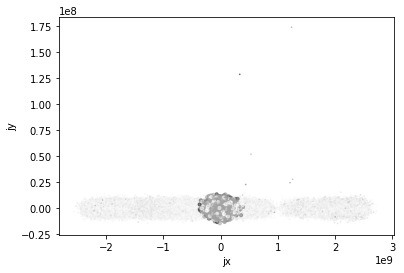

In [128]:
%matplotlib inline
iforest_plot['jx'] = jitter(iforest_plot['x'])
iforest_plot['jy'] = jitter(iforest_plot['y'])
# Now use dataframe group by cluster
iforest_cluster_groups = iforest_plot.groupby('train')
# Plot the Machine Learning results
iforest_size = {0:0.5, 1:10, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
# labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in iforest_cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=iforest_size[key], 
               color=iforest_plot[iforest_plot['train'] == key]['value'])

##### Creating CBLOF Model

In [129]:
from pyod.models.cblof import CBLOF

def cblof(train, valid, test, label):
    
    cblof = CBLOF(n_clusters = 10, contamination=0.3)
    cblof.fit(train)
    
    cblof_values = cblof.decision_function(valid)
    cblof_test_values = cblof.decision_function(test)

    return abs(cblof_values) / 100000000, abs(cblof_test_values) / 100000000

In [130]:
cblofs = []
cblof_tests = []
print("JOB STATUS")
print("**********")

counter = 0
for value in train:
    print("\nTraining {} model...".format(labels[counter]), end=" ")
    validScore, testScore = cblof(train[counter], valid[counter], test[counter], labels[counter])
    
    cblofs.append(validScore)
    cblof_tests.append(testScore)
    
    print("COMPLETED")
    
    counter += 1
    

JOB STATUS
**********

Training dns model... COMPLETED

Training conn model... COMPLETED

Training yaf model... COMPLETED

Training snort model... COMPLETED

Training meraki model... COMPLETED


##### Visualizing CBLOF Forest Model

In [131]:
counter = 0
cblof_list = []
for value in valid:
    cblof_list.append(visualize(value, test[counter], cblofs[counter], cblof_tests[counter]))
    counter += 1
cblof_plot = pd.concat(cblof_list)
cblof_plot.head()

,x,y,value,train
0,1.657442e+09,27237.439759,18.699908,0
1,-7.146014e+08,-33970.573699,5.020526,0
2,-4.532576e+08,45052.870818,2.407088,0
3,-1.421566e+08,46417.997052,0.703922,0
4,-4.539417e+08,27603.791237,2.413929,0


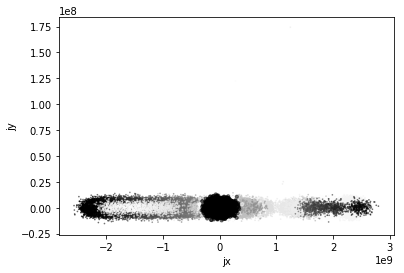

In [132]:
%matplotlib inline
cblof_plot['jx'] = jitter(cblof_plot['x'])
cblof_plot['jy'] = jitter(cblof_plot['y'])
# Now use dataframe group by cluster
cblof_cluster_groups = cblof_plot.groupby('train')
# Plot the Machine Learning results
cblof_size = {0:0.5, 1:10, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
# labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in cblof_cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=cblof_size[key], 
               color=cblof_plot[cblof_plot['train'] == key]['value'] * 1000)

##### Creating HBOS Model

In [133]:
from pyod.models.hbos import HBOS

def hbos(train, valid, test, label):
    
    hbos = HBOS(contamination=0.3)
    hbos.fit(train)
    
    hbos_values = hbos.decision_function(valid)
    hbos_test_values = hbos.decision_function(test)

    return abs(hbos_values) / 1000, abs(hbos_test_values) / 1000

In [134]:
hboss = []
hbos_tests = []
print("JOB STATUS")
print("**********")

counter = 0
for value in train:
    print("\nTraining {} model...".format(labels[counter]), end=" ")
    validScore, testScore = hbos(train[counter], valid[counter], test[counter], labels[counter])
    
    hboss.append(validScore)
    hbos_tests.append(testScore)
    
    print("COMPLETED")
    
    counter += 1

JOB STATUS
**********

Training dns model... COMPLETED

Training conn model... COMPLETED

Training yaf model... COMPLETED

Training snort model... COMPLETED

Training meraki model... COMPLETED


##### Visualizing HBOS Forest Model

In [135]:
counter = 0
hbos_list = []
for value in valid:
    hbos_list.append(visualize(value, test[counter], hboss[counter], hbos_tests[counter]))
    counter += 1
hbos_plot = pd.concat(hbos_list)
hbos_plot.head()

,x,y,value,train
0,1.657442e+09,27237.439759,0.142082,0
1,-7.146014e+08,-33970.573699,0.132981,0
2,-4.532576e+08,45052.870818,0.132761,0
3,-1.421566e+08,46417.997052,0.132761,0
4,-4.539417e+08,27603.791237,0.136752,0


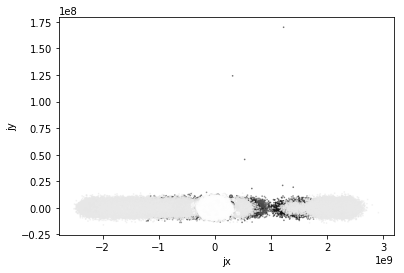

In [136]:
%matplotlib inline
hbos_plot['jx'] = jitter(hbos_plot['x'])
hbos_plot['jy'] = jitter(hbos_plot['y'])
# Now use dataframe group by cluster
hbos_cluster_groups = hbos_plot.groupby('train')
# Plot the Machine Learning results
hbos_size = {0:0.5, 1:10, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
# labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in hbos_cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=hbos_size[key], 
               color=hbos_plot[hbos_plot['train'] == key]['value'] * 1000)

##### Combining Models (DEMOCRATIC VOTING)

In [151]:
plot_values = []
plotT_values = []

model_valid = [iforests, hboss, cblofs]
model_test = [iforest_tests, hbos_tests, cblof_tests]

counter = 0

for value in model_valid:
    for element in value:
        plot_values.append(element)

for valueT in model_test:
    for elementT in valueT:
        plotT_values.append(elementT)

In [267]:
from functools import reduce

def combine(u):
    u.sort(key = lambda s: len(s))
    counter = 0
    smallest = 0
    combined = []
    final = []

    finished = True

    counter = 0
    smallest = 0
    moved = False

    for values in u[len(u) - 1]:
              
        if counter < len(u[smallest]):
            moved = False
            for x in range(smallest, len(u)):
                combined.append(u[x][counter])

            product = reduce((lambda x, y: x + y), combined)
            final.append(product / len(combined))

            combined = []
        
        if counter == len(u[smallest]) - 1:
            moved = True

        if moved:
            smallest += 1
        else:
            counter += 1
        
    return final

In [313]:
print("COMPILING VOTES")
print("***************")

print("Training Data:", end=" ")
new_lables = {0: "Isolation Forest", 1:"CBLOF",2:"HBOS" }

average_train = combine(plot_values)

counter = 0


for value in average_train:
    newVal = (value / len(average_train)) * 100
    average_train[counter] = newVal
    counter += 1
    
for x in range(3):
    print(new_lables[x], end = ", ")

print("\nTesting Data:", end=" ")

average_test = combine(plotT_values)

    
counter = 0

for value in average_test:
    newVal = (value / len(average_test)) 
    average_test[counter] = newVal
    counter += 1


for x in range(3):
    print(new_lables[x], end = ", ")

COMPILING VOTES
***************
Training Data: Isolation Forest, CBLOF, HBOS, 
Testing Data: Isolation Forest, CBLOF, HBOS, 

In [314]:
totalpca = []
for x in range(len(valid)):
    apca = PCA(n_components=2).fit_transform(valid[x])
    totalpca.append(apca)
    
pca = combine(totalpca)

pcaDf = pd.DataFrame(pca)

totalpcaT = []
for x in range(len(test)):
    apcaT = PCA(n_components=2).fit_transform(test[x])
    totalpcaT.append(apcaT)
    
pcaT = combine(totalpcaT)
pcaTDf = pd.DataFrame(pcaT)

plot_df = pd.DataFrame()
plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
plot_df['x'] = pcaDf[0] # PCA X Column
plot_df['y'] = pcaDf[1] # PCA Y Column
plot_df['value'] = average_train  
plot_df['train'] = 0

plot_dfT['x'] = pcaTDf[0] # PCA X Column
plot_dfT['y'] = pcaTDf[1] # PCA Y Column
plot_dfT['value'] = average_test
plot_dfT['train'] = 1

plot = pd.concat([plot_df, plot_dfT])

plot.head()

,x,y,value,train
0,1.194843e+09,-43987.492931,0.002772,0
1,-1.125646e+08,-16146.937513,0.002797,0
2,-8.562330e+07,13966.027066,0.000933,0
3,-3.842381e+08,-32619.624921,0.002657,0
4,7.280402e+08,2056.461819,0.002419,0


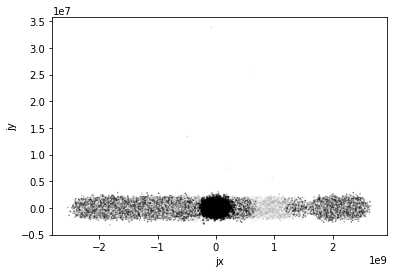

In [316]:
%matplotlib inline
plot['jx'] = jitter(plot['x'])
plot['jy'] = jitter(plot['y'])
# Now use dataframe group by cluster
cluster_groups = plot.groupby('train')
# Plot the Machine Learning results
size = {0:0.5, 1:2, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=size[key], 
               color=plot[plot['train'] == key]['value'])

##### KIBANA Virtualization

In [317]:
index_name = 'outlier_detection'

from elasticsearch import Elasticsearch

es.indices.delete(index=index_name, ignore=[400, 404])


print("REMOVING PAST DATA...")
print("COMPLETED")

REMOVING PAST DATA...
COMPLETED


In [318]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

plot.reset_index()
a_iter = plot.iterrows()
index, document = next(a_iter)
ids = np.arange(0, plot.size, dtype='int32')

myId = pd.Series(ids)


plot['id'] = myId
plot.head()

,x,y,value,train,jx,jy,id
0,1.194843e+09,-43987.492931,0.002772,0,1.141047e+09,-72987.949221,0
1,-1.125646e+08,-16146.937513,0.002797,0,-2.518247e+08,-759043.502042,1
2,-8.562330e+07,13966.027066,0.000933,0,-1.692680e+08,-248160.319295,2
3,-3.842381e+08,-32619.624921,0.002657,0,-4.365462e+08,-204677.488145,3
4,7.280402e+08,2056.461819,0.002419,0,7.273118e+08,-59279.677204,4


In [319]:
use_these_keys = ['x', 'y', 'value', 'train', 'jx', 'jy']

def filterKeys(document):
    return {key: document[key] for key in use_these_keys }

In [320]:
def doc_generator(df):
    dns_iter = df.iterrows()
    for index, document in dns_iter:
        yield {
                "_index": index_name,
                "_type": "yaf_doc",
                "_id" : f"{document['id']}",
                "_source": filterKeys(document),
            }
    raise StopIteration

In [321]:
helpers.bulk(es, doc_generator(plot))

RuntimeError: generator raised StopIteration

In [322]:
print('METRICS')
print('*******')

asum = plot[plot['train'] == 0]['value'].sum()
anavg = asum/plot[plot['train'] == 0]['value'].size
summary = plot[plot['train'] == 0]['value'].describe()

print("Sum of Previous Data: {}".format(asum))
print("Average of Previous Data: {}".format(anavg))
print(summary)

METRICS
*******
Sum of Previous Data: 576.699592375316
Average of Previous Data: 0.004336087160716662
count    133000.000000
mean          0.004336
std           0.003460
min           0.000023
25%           0.000957
50%           0.003830
75%           0.007694
max           0.010508
Name: value, dtype: float64


In [ ]:
from scipy import stats

t2, p2 = stats.ttest_ind(dns_testVal,dns_trainVal)
print("t-value:{}".format(t2))
print("p-value: {}".format(p2))

##### CONN Data

In [ ]:
conn_cols = list(conn_df.columns)
CdroppedList = []


print("TRAINING DATA")
print("************")
print("COLUMNS CHECKED:", end = " ") 

for columnC in conn_cols:
    if conn_df[columnC].isna().all():
        CdroppedList.append(columnC)
    else:
        if list(conn_df[columnC].isna())[0]:
            conn_df.loc[:,columnC].fillna(method='bfill', inplace=True)
        else:
            conn_df.loc[:,columnC].fillna(method='pad', inplace=True)
        print(columnC + ",", end = " ")

conn_df.drop(CdroppedList, axis=1, inplace= True)
conn_df.head()

In [ ]:
conn_colsT = list(conn_dfT.columns)
droppedListCT = []

print("TESTING DATA")
print("************")
print("COLUMNS CHECKED:", end = " ") 

for columnCT in conn_colsT:
    if conn_dfT[columnCT].isna().all():
        droppedListCT.append(columnCT)
    else:
        if list(conn_dfT[columnCT].isna())[0]:
            conn_dfT.loc[:,columnCT].fillna(method='bfill', inplace=True)
        else:
            conn_dfT.loc[:,columnCT].fillna(method='pad', inplace=True)
        print(columnCT + ",", end = " ")
        

conn_dfT.drop(droppedListCT, axis=1, inplace=True)
conn_dfT.head()

In [ ]:
conn_cols = list(conn_df.columns)
conn_colsT = list(conn_dfT.columns)
toDropC = []
toDropCT = []

for columnC in conn_cols:
    if columnC not in conn_colsT:
        toDropC.append(columnC)

for columnCT in conn_colsT:
    if columnCT not in conn_cols:
        toDropCT.append(columnCT)
print(toDropC)

conn_df.drop(toDropC, axis=1, inplace=True)
conn_dfT.drop(toDropCT, axis=1, inplace=True)      

##### Creating Isolation Forest Model

In [ ]:
conn_train, conn_valid = train_test_split(conn_df, test_size = 0.35)

In [ ]:
conn_iforest = IsolationForest(n_estimators = 5, max_samples = 32220, contamination='auto', behaviour="new")
conn_iforest.fit(conn_train)

In [ ]:
conn_iforest_pred_train = conn_iforest.predict(conn_valid)
conn_iforest_pred_test = conn_iforest.predict(conn_dfT)

conn_iforest_plot_values = conn_iforest.decision_function(conn_valid)
conn_iforest_plotT_values = conn_iforest.decision_function(conn_dfT)

conn_plot_values.append(abs(conn_iforest_plot_values))
conn_plotT_values.append(abs(conn_iforest_plotT_values))

##### Visualizing Isolation Forest Model

In [ ]:
conn_iforest_pca = PCA(n_components=2).fit_transform(conn_valid)
conn_iforest_pcaT = PCA(n_components=2).fit_transform(conn_dfT)

conn_iforest_plot_df = pd.DataFrame()
conn_iforest_plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
conn_iforest_plot_df['x'] = conn_iforest_pca[:, 0] # PCA X Column
conn_iforest_plot_df['y'] = conn_iforest_pca[:, 1] # PCA Y Column
conn_iforest_plot_df['value'] = conn_iforest_plot_values
conn_iforest_plot_df['train'] = 0


conn_iforest_plot_dfT['x'] = conn_iforest_pcaT[:, 0] # PCA X Column
conn_iforest_plot_dfT['y'] = conn_iforest_pcaT[:, 1] # PCA Y Column
conn_iforest_plot_dfT['value'] = conn_iforest_plotT_values
conn_iforest_plot_dfT['train'] = 1

conn_iforest_plot = pd.concat([conn_iforest_plot_df, conn_iforest_plot_dfT])

conn_iforest_plot.head()

In [ ]:
%matplotlib inline
conn_iforest_plot['jx'] = jitter(conn_iforest_plot['x'])
conn_iforest_plot['jy'] = jitter(conn_iforest_plot['y'])
# Now use dataframe group by cluster
iforest_cluster_groups = conn_iforest_plot.groupby('train')
# Plot the Machine Learning results
iforest_size = {0:0.5, 1:10, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in iforest_cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=iforest_size[key], 
               color=conn_iforest_plot[conn_iforest_plot['train'] == key]['value'])

##### Creating CBLOF Model

In [ ]:
conn_cblof = CBLOF(contamination=0.3)
conn_cblof.fit(conn_train)

In [ ]:
conn_cblof_pred_train = conn_cblof.predict(conn_valid)
conn_cblof_pred_test = conn_cblof.predict(conn_dfT)

conn_cblof_plot_values = conn_cblof.decision_function(conn_valid)
conn_cblof_plotT_values = conn_cblof.decision_function(conn_dfT)

conn_plot_values.append(conn_cblof_plot_values / 100000000)
conn_plotT_values.append(conn_cblof_plotT_values / 100000000)

##### Visualizing CBLOF  Model

In [ ]:
conn_cblof_pca = PCA(n_components=2).fit_transform(conn_valid)
conn_cblof_pcaT = PCA(n_components=2).fit_transform(conn_dfT)

conn_cblof_plot_df = pd.DataFrame()
conn_cblof_plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
conn_cblof_plot_df['x'] = conn_cblof_pca[:, 0] # PCA X Column
conn_cblof_plot_df['y'] = conn_cblof_pca[:, 1] # PCA Y Column
conn_cblof_plot_df['value'] = conn_cblof_plot_values / 10000000
conn_cblof_plot_df['train'] = 0


conn_cblof_plot_dfT['x'] = conn_cblof_pcaT[:, 0] # PCA X Column
conn_cblof_plot_dfT['y'] = conn_cblof_pcaT[:, 1] # PCA Y Column
conn_cblof_plot_dfT['value'] = conn_cblof_plotT_values / 10000000
conn_cblof_plot_dfT['train'] = 1

conn_cblof_plot = pd.concat([conn_cblof_plot_df, conn_cblof_plot_dfT])

conn_cblof_plot.head()

In [ ]:
%matplotlib inline
conn_cblof_plot['jx'] = jitter(conn_cblof_plot['x'])
conn_cblof_plot['jy'] = jitter(conn_cblof_plot['y'])
# Now use dataframe group by cluster
cblof_cluster_groups = conn_cblof_plot.groupby('train')
# Plot the Machine Learning results
cblof_size = {0:0.5, 1:10, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in cblof_cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=cblof_size[key], 
               color=conn_cblof_plot[conn_cblof_plot['train'] == key]['value'] * 1000)

##### HBOS Model

In [ ]:
from pyod.models.hbos import HBOS
conn_hbos = HBOS(contamination=0.3)
conn_hbos.fit(conn_train)

In [ ]:
conn_hbos_pred_train = conn_hbos.predict(conn_valid)
conn_hbos_pred_test = conn_hbos.predict(conn_dfT)

conn_hbos_plot_values = conn_hbos.decision_function(conn_valid)
conn_hbos_plotT_values = conn_hbos.decision_function(conn_dfT)

conn_plot_values.append(conn_hbos_plot_values / 10000)
conn_plotT_values.append(conn_hbos_plotT_values / 10000)

##### Visualizing HBOS Model

In [ ]:
conn_hbos_pca = PCA(n_components=2).fit_transform(conn_valid)
conn_hbos_pcaT = PCA(n_components=2).fit_transform(conn_dfT)

conn_hbos_plot_df = pd.DataFrame()
conn_hbos_plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
conn_hbos_plot_df['x'] = conn_hbos_pca[:, 0] # PCA X Column
conn_hbos_plot_df['y'] = conn_hbos_pca[:, 1] # PCA Y Column
conn_hbos_plot_df['value'] = conn_hbos_plot_values / 100
conn_hbos_plot_df['train'] = 0


conn_hbos_plot_dfT['x'] = conn_hbos_pcaT[:, 0] # PCA X Column
conn_hbos_plot_dfT['y'] = conn_hbos_pcaT[:, 1] # PCA Y Column
conn_hbos_plot_dfT['value'] = conn_hbos_plotT_values / 100
conn_hbos_plot_dfT['train'] = 1

conn_hbos_plot = pd.concat([conn_hbos_plot_df, conn_hbos_plot_dfT])

conn_hbos_plot.head()

In [ ]:
%matplotlib inline
conn_hbos_plot['jx'] = jitter(conn_hbos_plot['x'])
conn_hbos_plot['jy'] = jitter(conn_hbos_plot['y'])
# Now use dataframe group by cluster
hbos_cluster_groups = conn_hbos_plot.groupby('train')
# Plot the Machine Learning results
hbos_size = {0:0.5, 1:10, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in hbos_cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=hbos_size[key], 
               color=conn_hbos_plot[conn_hbos_plot['train'] == key]['value'] * 1000)

##### COMBINING MODELS (DEMOCRATIC VOTING)

In [ ]:
counterC = 0
counterCT = 0
conn_testVal = []
conn_trainVal = []
prevVal = []

print("COMPILING VOTES")
print("***************")

print("Training Data:", end=" ")
lablesC = {0: "Isolation Forest", 1:"CBLOF",2:"HBOS" }

for x in range(3):
    print(lablesC[x], end = ", ")


for valueC in conn_plot_values:
    
    if counterC == 0:
        for aValC in valueC:
            conn_trainVal.append(aValC)
    else:
        for xC in range(valueC.size):
            oldValueC = conn_trainVal[xC]
            newValueC = oldValueC + valueC[xC]
            conn_trainVal[xC] = newValueC
        
    counterC += 1
    
for wC in range(len(conn_trainVal)):
    oldValC = conn_trainVal[wC]
    newValC = oldValC / counterC
    conn_trainVal[wC] = newValC
        

print("\nTesting Data:", end=" ")

for valueCT in conn_plotT_values:
    
    if counterCT == 0:
        for aValCT in valueCT:
            conn_testVal.append(aValCT)
    else:
        for xCT in range(valueCT.size):
            oldValueCT = conn_testVal[xCT]
            newValueCT = oldValueCT + valueCT[xCT]
            conn_testVal[xCT] = newValueCT
        
    counterCT += 1
    
for wCT in range(len(conn_testVal)):
    oldValCT = conn_testVal[wCT]
    newValCT = oldValCT / counterCT
    conn_testVal[wCT] = newValCT

    
for xC in range(3):
    print(lables[xC], end = ", ")


In [ ]:
conn_pca = PCA(n_components=2).fit_transform(conn_valid)
conn_pcaT = PCA(n_components=2).fit_transform(conn_dfT)

conn_plot_df = pd.DataFrame()
conn_plot_dfT = pd.DataFrame()
# Now we can put our ML results back onto our dataframe!
conn_plot_df['x'] = conn_pca[:, 0] # PCA X Column
conn_plot_df['y'] = conn_pca[:, 1] # PCA Y Column
conn_plot_df['value'] = conn_trainVal  
conn_plot_df['train'] = 0


conn_plot_dfT['x'] = conn_pcaT[:, 0] # PCA X Column
conn_plot_dfT['y'] = conn_pcaT[:, 1] # PCA Y Column
conn_plot_dfT['value'] = conn_testVal[:conn_pcaT[:, 0].size]
conn_plot_dfT['train'] = 1

conn_plot = pd.concat([conn_plot_df, conn_plot_dfT])

conn_plot.head()

In [ ]:
%matplotlib inline
conn_plot['jx'] = jitter(conn_plot['x'])
conn_plot['jy'] = jitter(conn_plot['y'])
# Now use dataframe group by cluster
cluster_groups = conn_plot.groupby('train')
# Plot the Machine Learning results
size = {0:0.5, 1:2, 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
labels = {0:'_source.ip_dst_port', 1:'_source.ip_dst_addr', 2:'_source.bro_timestamp', 3:'_source.uid', 4: '_source.trans_id'}
for key, group in cluster_groups:
    #count += 1
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=size[key], 
               color=conn_plot[conn_plot['train'] == key]['value'])

##### KIBANA Virtualization

In [ ]:
index_name_conn = 'conn_visualization'

from elasticsearch import Elasticsearch

es.indices.delete(index=index_name_conn, ignore=[400, 404])


print("REMOVING PAST DATA...")
print("COMPLETED")

In [ ]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

conn_plot.reset_index()
conn_iter = conn_plot.iterrows()
index, document = next(conn_iter)
conn_ids = np.arange(0, conn_plot.size, dtype='int32')

connId = pd.Series(conn_ids)

conn_plot['id'] = connId
conn_plot.head()

In [ ]:
use_these_keys = ['x', 'y', 'value', 'train', 'jx', 'jy']

def filterKeys(document):
    return {key: document[key] for key in use_these_keys }

In [ ]:
def doc_generator(df):
    conn_iter = df.iterrows()
    for index, document in conn_iter:
        yield {
                "_index": index_name_conn,
                "_type": "conn_doc",
                "_id" : f"{document['id']}",
                "_source": filterKeys(document),
            }
    raise StopIteration

In [ ]:
helpers.bulk(es, doc_generator(conn_plot))